# Spotify Project: Vanguard

Zara Saldanha

In [1]:
# If you would like to use different artists, please edit artist_list below and restart the whole notebook 
artist_list = ['Elvis Presley',
           'Post Malone',
           'Kanye West',
           'Drake',
           'Red Hot Chili Peppers',
           'The Weeknd',
           'Machine Gun Kelly',
           'Cardi B',
           'Billie Eilish',
           'Juice WRLD',
           'Queen',
           'Lenny Kravitz',
           'Elton John',
           'Tom Petty',
           'Led Zeppelin',
           'Bon Jovi',
           'Prince',
           'Michael Jackson',
           'AC/DC',
           'Flume']

## Part 1: Ingestion

### Import Statements

In [2]:
import spotipy
import pandas as pd
import numpy as np
from pprint import pprint
import sys
import os
from spotipy.oauth2 import SpotifyClientCredentials
import sqlite3
from sqlalchemy import create_engine
from sqlite3 import Error

### Set up Credentials

In [3]:
## go back and create config files or declare environment vars in terminal
os.environ["SPOTIPY_CLIENT_ID"] = "66ea1fd086944db888acdbf371ebfda1"
os.environ["SPOTIPY_CLIENT_SECRET"] = "8e6033fc4bab4c0ea99e9a79f7743a21"
spotify = spotipy.Spotify(client_credentials_manager=SpotifyClientCredentials())

### Create Table Functions

In [4]:
# input: list of artists as strings
# output: artist dataframe

def create_artist_df(artist_list):
    artists_df = pd.DataFrame()
    
    for artist in artist_list:
        results = spotify.search(q=artist, type='artist')
        items = results['artists']['items']


        if len(items) > 0:
            artist = items[0]
            artist_data = {'artist_id': artist['id'],
                   'artist_name': artist['name'],
                   'external_url': artist['external_urls']['spotify'],
                   'genre': artist['genres'],
                   'image_url': artist['images'][0]['url'],
                   'followers': artist['followers']['total'],
                   'popularity': artist['popularity'],
                   'type': artist['type'],
                   'artist_uri': artist['uri']}
            df = pd.DataFrame(artist_data)
            artists_df=pd.concat([artists_df,df.iloc[:1]],ignore_index=True)
    return artists_df

# input: list of artist IDs as strings
# output: album dataframe

def create_album_df(artist_ids):
    
    albums_df=pd.DataFrame()
    #album_ids=[]
    
    for artist_id in artist_ids:
        results = spotify.artist_albums(artist_id, country='US', limit=20)

        #albums_df = pd.DataFrame(columns = ['album_id', 'album_name', 'external_url','image_url','release_date', 'total_tracks','type','album_uri','artist_id'])
        items = results['items']
        album_prev=items[0]['name']
        i=0

        while i < len(items):
            album = items[i]
            if album['name'] == album_prev:
                i+=1
                pass
            else:
                album_data = {'album_id': [album['id']],
                          'album_name': [album['name']],
                          'external_url': [album['external_urls']['spotify']],
                          'image_url': [album['images'][0]['url']], 
                          'release_date': [album['release_date']],
                         'total_tracks': [album['total_tracks']],
                         'type': [album['type']],
                         'album_uri': [album['uri']],
                         'artist_id': [album['artists'][0]['id']]}
                album_df = pd.DataFrame(album_data)
               # album_ids.append(album['id'])
                albums_df=pd.concat([albums_df,album_df],ignore_index=True)
                album_prev=album['name']
                i+=1 
                
    return albums_df

# input: list of album IDs as strings
# output: tracks dataframe

def create_tracks_df(album_ids):

    album_tracks = pd.DataFrame()

    for album_id in album_ids:
        results = spotify.album_tracks(album_id)
        items = results['items']
        i=0

        while i < len(items):
            track = items[i]
            track_data = {'track_id': [track['id']],
                      'song_name': [track['name']],
                      'external_url': [track['external_urls']['spotify']],
                      'duration_ms': [track['duration_ms']], 
                      'explicit': [track['explicit']],
                     'disc_number': [track['disc_number']],
                     'type': [track['type']],
                     'song_uri': [track['uri']],
                     'album_id': album_id }
            track_df = pd.DataFrame(track_data)
            album_tracks=pd.concat([album_tracks,track_df],ignore_index=True)
            i+=1
    return album_tracks

# input: list of track IDs as strings
# output: track features dataframe

def create_features_df(track_id_list):
    track_df = pd.DataFrame()
    num_tracks = len(track_id_list)
    num_loop = num_tracks//100
    num_remainder = num_tracks%100
    
    x=0
    
    while x< num_loop*100:
        results = spotify.audio_features(track_id_list[x:x+100])
        cols = ['id','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','type','uri']
        track_features=pd.DataFrame(results)[cols]
        track_df=pd.concat([track_df,track_features],ignore_index=True)
        x=x+100
    
    if num_remainder != 0:
        results = spotify.audio_features(track_id_list[x:x+num_remainder])
        cols = ['id','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','type','uri']
        track_features=pd.DataFrame(results)[cols]
        track_df=pd.concat([track_df,track_features],ignore_index=True)
    
    return track_df

### Combine into single function

In [5]:
def create_dataframes(artists):
    artists = create_artist_df(artists)
    albums = create_album_df(artists.artist_id.tolist())
    tracks = create_tracks_df(albums.album_id.tolist())
    track_features = create_features_df(tracks.track_id.tolist())
    return artists,albums,tracks,track_features

### Create Dataframes from Artist List

In [6]:
%%time

artists_df,albums_df,tracks_df,track_features_df = create_dataframes(artist_list)

CPU times: user 7.19 s, sys: 309 ms, total: 7.5 s
Wall time: 56.2 s


## Part 2: Transformation

#### Check for Null Values

In [7]:
for i in artists_df,albums_df,tracks_df,track_features_df:
    print(i.isna().all().all())

False
False
False
False


In [8]:
# uncomment if any of the above is True
'''
artists.isna().sum()
albums.isna().sum()
tracks.isna().sum()
track_features.isna().sum()
'''

'\nartists.isna().sum()\nalbums.isna().sum()\ntracks.isna().sum()\ntrack_features.isna().sum()\n'

#### Remove Duplicates

In [9]:
artists_df = artists_df.drop_duplicates()
albums_df = albums_df.drop_duplicates()
tracks_df = tracks_df.drop_duplicates()
track_features_df = track_features_df.drop_duplicates()

In [10]:
# Check duplicates if exists
'''
duplicate = albums[albums.duplicated()]
duplicate
'''

'\nduplicate = albums[albums.duplicated()]\nduplicate\n'

### Rename Columns

In [11]:
track_features_df.rename(columns = {'id':'track_id'}, inplace = True)
track_features_df.rename(columns = {'uri':'song_uri'}, inplace = True)

## Part 3: Storage

In [12]:
# https://www.sqlitetutorial.net/sqlite-python/creating-tables/

import sqlite3
from sqlite3 import Error

def drop_table(conn, drop_table_sql):
    try:
        c = conn.cursor()
        c.execute(drop_table_sql)
    except Error as e:
        print(e)


def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

def main():
    database = r"spotify.db"
    
    # Drop table queries
    artist_table_drop = "DROP table IF EXISTS artist"
    album_table_drop = "DROP table IF EXISTS album"
    track_table_drop = "DROP table IF EXISTS track"
    feature_table_drop = "DROP table IF EXISTS track_feature"
    
    
    # Create artist table query
    artist_table_create = ("""CREATE TABLE IF NOT EXISTS artist
                         (artist_id text PRIMARY KEY,
                         artist_name text,
                         external_url text,
                         genre text,
                         image_url text,
                         followers integer,
                         popularity integer,
                         type TEXT,
                         artist_uri text )""")

    # Create album table query
    album_table_create = ("""CREATE TABLE IF NOT EXISTS album
                     (album_id text PRIMARY KEY,
                     album_name text,
                     external_url text,
                     image_url text,
                     release_date numeric,
                     total_tracks integer,
                     type text,
                     album_uri text,
                     artist_id text)""")

    # Create track table query
    track_table_create = ("""CREATE TABLE IF NOT EXISTS track
                     (track_id text PRIMARY KEY,
                     song_name text,
                     external_url text,
                     duration_ms integer,
                     explicit numeric,
                     disc_number integer,
                     type text,
                     song_uri text,
                     album_id text)""")

    # Create track_feature table query
    feature_table_create = ("""CREATE TABLE IF NOT EXISTS track_feature
                       (track_id text PRIMARY KEY,
                       danceability real,
                       energy real,
                       instrumentalness real,
                       liveness real,
                       loudness real,
                       speechiness real,
                       tempo real,
                       type text,
                       valence real,
                       song_uri text)""")
    
    # create a database connection
    conn = create_connection(database)

    # create tables
    if conn is not None:
        
        #drop tables
        drop_table(conn, artist_table_drop)
        drop_table(conn, album_table_drop)
        drop_table(conn, track_table_drop)
        drop_table(conn, feature_table_drop)
        
        # create artist table
        create_table(conn, artist_table_create)

        # create album table
        create_table(conn, album_table_create)
        
        # create track table
        create_table(conn, track_table_create)
        
        # create track feature table
        create_table(conn, feature_table_create)
        
    else:
        print("Error! cannot create the database connection.")


if __name__ == '__main__':
    main()

In [13]:
# uncomment to check if table is empty
'''
database = r"spotify.db"
conn = create_connection(database)
c = conn.cursor()
c.execute("SELECT * FROM artist")
query = "select * from artist"
df = pd.read_sql_query(query, conn)
df
'''

'\ndatabase = r"spotify.db"\nconn = create_connection(database)\nc = conn.cursor()\nc.execute("SELECT * FROM artist")\nquery = "select * from artist"\ndf = pd.read_sql_query(query, conn)\ndf\n'

In [14]:
engine = create_engine('sqlite:///spotify.db', echo=False)
artists_df.to_sql('artist', con=engine, if_exists='append',index=False)
albums_df.to_sql('album', con=engine, if_exists='append', index=False)
tracks_df.to_sql('track', con=engine, if_exists='append', index=False)
track_features_df.to_sql('track_feature', con=engine, if_exists='append', index=False)

4481

## Part 4: Analytics and Visualization

### Create Views

In [15]:
# View 1: Top songs by artist in terms of duration_ms
# Top 10 longest songs on Spotify for each artist ordered by duration_ms descending

database = r"spotify.db"
conn = create_connection(database)

drop_query = '''
DROP VIEW IF EXISTS top_songs_duration;
'''
c = conn.cursor()
c.execute(drop_query)

query = '''
CREATE VIEW top_songs_duration
AS

WITH top_songs AS (
SELECT song_name, track_id, artist_name, c.artist_id, album_name, b.album_id, duration_ms,
row_number() over (partition by artist_name order by duration_ms desc) as duration_rank
FROM
track a LEFT JOIN album b
ON a.album_id=b.album_id
LEFT JOIN artist c
ON b.artist_id = c.artist_id
ORDER BY artist_name
)

SELECT song_name, track_id, artist_name, artist_id, album_name, album_id, duration_ms, duration_rank
FROM top_songs
WHERE duration_rank <= 10
and artist_name <> 'None'
ORDER BY duration_ms DESC
'''

c = conn.cursor()
c.execute(drop_query)
c.execute(query)

In [16]:
# View 2: Top artists by # of followers

database = r"spotify.db"
conn = create_connection(database)

drop_query = '''
DROP VIEW IF EXISTS top_artists;
'''
c = conn.cursor()
c.execute(drop_query)

query = '''
CREATE VIEW top_artists
AS
SELECT *
FROM
artist
ORDER BY followers DESC
'''

c = conn.cursor()
c.execute(drop_query)
c.execute(query)

In [17]:
# View 3: Top songs by artist in terms of tempo

database = r"spotify.db"
conn = create_connection(database)

drop_query = '''
DROP VIEW IF EXISTS top_songs_tempo;
'''
c = conn.cursor()
c.execute(drop_query)

query = '''
CREATE VIEW top_songs_tempo
AS

WITH top_songs AS (
SELECT song_name, t.track_id, artist_name, c.artist_id, album_name, b.album_id, tempo,
row_number() over (partition by artist_name order by tempo desc) as tempo_rank
FROM
track_feature t LEFT JOIN track a
ON t.track_id = a.track_id
LEFT JOIN album b
ON a.album_id=b.album_id
LEFT JOIN artist c
ON b.artist_id = c.artist_id
ORDER BY tempo DESC
)

SELECT song_name, track_id, artist_name, artist_id, album_name, album_id, tempo, tempo_rank
FROM top_songs
WHERE tempo_rank <= 10
and artist_name <> 'None'
ORDER BY tempo DESC
'''

c = conn.cursor()
c.execute(drop_query)
c.execute(query)

In [18]:
# View 4: Top artists by number of explicit songs

database = r"spotify.db"
conn = create_connection(database)

drop_query = '''
DROP VIEW IF EXISTS top_artists_explicit;
'''
c = conn.cursor()
c.execute(drop_query)

query = '''
CREATE VIEW top_artists_explicit
AS

SELECT artist_name, c.artist_id, sum(explicit) as explicit_songs
FROM
track_feature t LEFT JOIN track a
ON t.track_id = a.track_id
LEFT JOIN album b
ON a.album_id=b.album_id
LEFT JOIN artist c
ON b.artist_id = c.artist_id
GROUP BY artist_name
ORDER BY explicit_songs DESC

'''

c = conn.cursor()
c.execute(drop_query)
c.execute(query)

In [19]:
# View 5: Top albums by number of songs

database = r"spotify.db"
conn = create_connection(database)

drop_query = '''
DROP VIEW IF EXISTS top_albums;
'''
c = conn.cursor()
c.execute(drop_query)

query = '''
CREATE VIEW top_albums
AS
SELECT album_name, b.album_id, artist_name, c.artist_id,  count(t.track_id) as num_songs
FROM
track_feature t LEFT JOIN track a
ON t.track_id = a.track_id
LEFT JOIN album b
ON a.album_id=b.album_id
LEFT JOIN artist c
ON b.artist_id = c.artist_id
GROUP BY album_name
ORDER BY num_songs DESC

'''

c = conn.cursor()
c.execute(drop_query)
c.execute(query)

In [20]:
# View 6: 'Live' songs

database = r"spotify.db"
conn = create_connection(database)

drop_query = '''
DROP VIEW IF EXISTS live_songs;
'''
c = conn.cursor()
c.execute(drop_query)

query = '''
CREATE VIEW live_songs
AS
SELECT song_name, t.track_id, artist_name, c.artist_id, album_name, b.album_id
FROM
track_feature t LEFT JOIN track a
ON t.track_id = a.track_id
LEFT JOIN album b
ON a.album_id=b.album_id
LEFT JOIN artist c
ON b.artist_id = c.artist_id
WHERE song_name LIKE '%live%'
and artist_name <> 'None'
ORDER BY artist_name

'''

c = conn.cursor()
c.execute(drop_query)
c.execute(query)

In [21]:
# View 7: 'Remastered' songs

database = r"spotify.db"
conn = create_connection(database)

drop_query = '''
DROP VIEW IF EXISTS remastered_songs;
'''
c = conn.cursor()
c.execute(drop_query)

query = '''
CREATE VIEW remastered_songs
AS
SELECT song_name, t.track_id, artist_name, c.artist_id, album_name, b.album_id
FROM
track_feature t LEFT JOIN track a
ON t.track_id = a.track_id
LEFT JOIN album b
ON a.album_id=b.album_id
LEFT JOIN artist c
ON b.artist_id = c.artist_id
WHERE song_name LIKE '%remaster%'
and artist_name <> 'None'
ORDER BY artist_name

'''

c = conn.cursor()
c.execute(drop_query)
c.execute(query)

In [22]:
# View 8: All dataframes joined

database = r"spotify.db"
conn = create_connection(database)

drop_query = '''
DROP VIEW IF EXISTS full;
'''
c = conn.cursor()
c.execute(drop_query)

query = '''
CREATE VIEW full
AS
SELECT *
FROM
track_feature t LEFT JOIN track a
ON t.track_id = a.track_id
LEFT JOIN album b
ON a.album_id=b.album_id
LEFT JOIN artist c
ON b.artist_id = c.artist_id
WHERE artist_name <> 'None'
ORDER BY artist_name
'''

c = conn.cursor()
c.execute(drop_query)
c.execute(query)

## Visualizations

In [23]:
import seaborn as sns

In [24]:
query = '''
SELECT *
FROM
full
'''

full_df = pd.read_sql_query(query, conn)

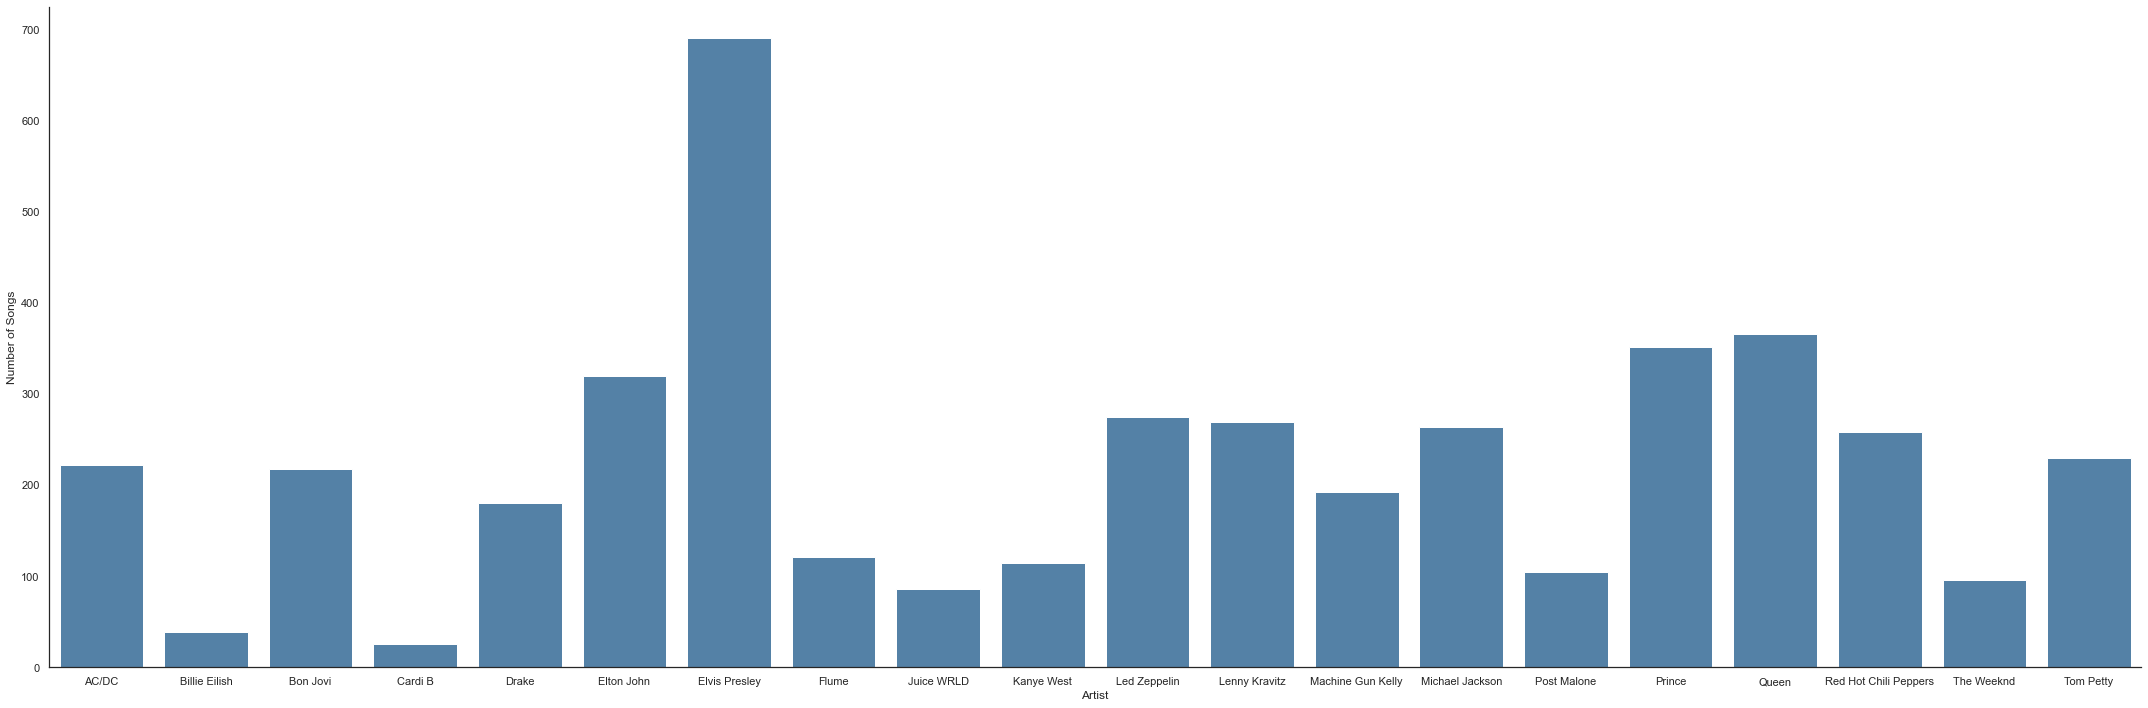

In [25]:
sns.set(rc = {'figure.figsize':(15,8)})
with sns.axes_style('white'):
    g = sns.catplot(x="artist_name", data=full_df, height=10, aspect=3,
                       kind="count", color='steelblue')

g.set_axis_labels("Artist", "Number of Songs")
g.set_titles("Number of Songs per Artist")

In [26]:
query = '''
SELECT track_id, song_name, duration_ms, artist_name, artist_id, danceability, energy, instrumentalness, liveness, loudness, speechiness, tempo
FROM
full
'''

df = pd.read_sql_query(query, conn)

Text(0.5, 1.0, 'Correlation Matrix for Audio Features')

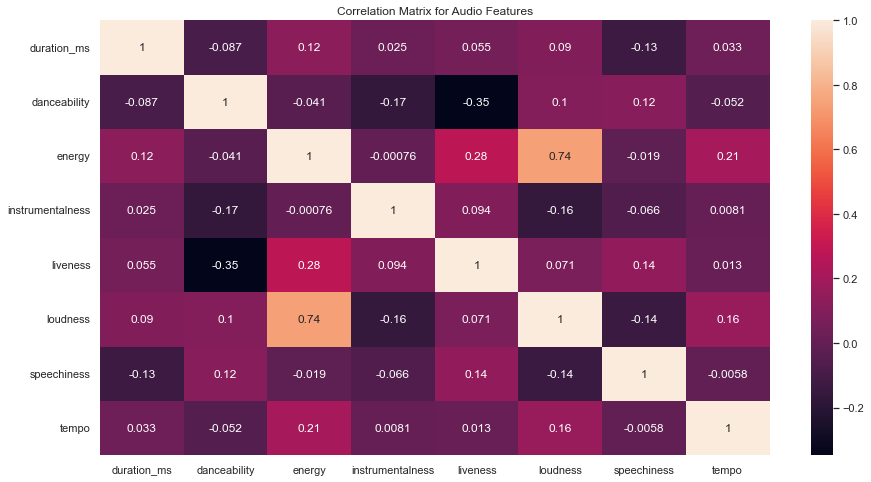

In [27]:
ax = sns.heatmap(df.corr(), annot=True)
ax.set_title("Correlation Matrix for Audio Features")

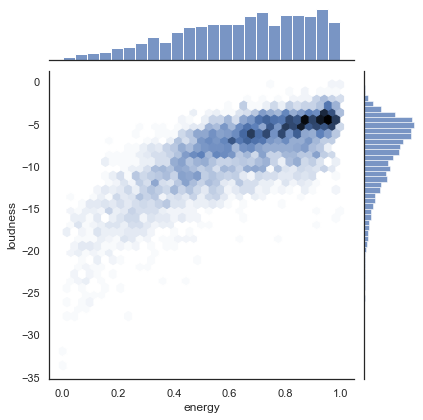

In [28]:
# Viz 4

with sns.axes_style('white'):
    sns.jointplot(x="energy", y="loudness", data=df, kind='hex')

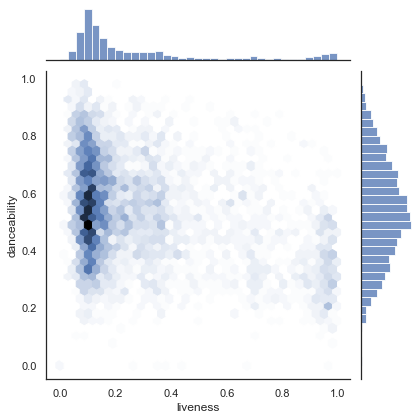

In [29]:
with sns.axes_style('white'):
    sns.jointplot(x="liveness", y="danceability", data=df, kind='hex')